In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,accuracy_score
from sklearn.model_selection import GroupKFold
from xgboost import XGBRegressor

import joblib
sns.set(style="whitegrid")


In [2]:
DATA_DIR=Path("..")/"data/processed"
MODEL_DIR=Path("..")/"models"

FD="FD004"

train_df=pd.read_csv(DATA_DIR/f"train_features_{FD}.csv")
test_df=pd.read_csv(DATA_DIR/f"test_features_{FD}.csv")

FEATURES=joblib.load(MODEL_DIR/"feature_list.pkl")

train_df.shape,test_df.shape

((61249, 52), (41214, 51))

In [3]:
X=train_df[FEATURES].values
y=train_df['RUL_Value'].values
groups=train_df["unit"].values

In [4]:
X_tr=X[[0,1,2,3]]
X_tr.shape

(4, 50)

In [5]:
#using RandomForestRegressor 
# gkf=GroupKFold(n_splits=5)

# mae_=[]
# rmse_=[]

# for fold,(train_idx,val_idx) in enumerate(gkf.split(X,y,groups)):
#     X_train = X[train_idx]
#     X_vald=X[val_idx]
#     y_train=y[train_idx]
#     y_vald=y[val_idx]

#     model=RandomForestRegressor(
#         n_estimators=300,
#         max_depth=None,
#         min_samples_leaf=2,
#         n_jobs=-1,
#         random_state=42
#     )

#     model.fit(X_train,y_train)
#     preds=model.predict(X_vald)

#     mae=mean_absolute_error(y_vald,preds)
#     rmse=np.sqrt(mean_squared_error(y_vald,preds))

#     print(f" Fold {fold+1} -> MAE= {mae}, RMSE= {rmse}")

#     mae_.append(mae)
#     rmse_.append(rmse)

# print("Root squared mean error:", np.mean(mae_))
# print("Mean Absolute Error:",np.mean(rmse_))

In [6]:
gkf1=GroupKFold(n_splits=5)
mae1_=[]
rmse1_=[]

for fold, (X_trIdx,X_valIdx) in enumerate(gkf1.split(X,y,groups)):
    X_train1= X[X_trIdx]
    y_train1=y[X_trIdx]
    X_vald1=X[X_valIdx]
    y_vald1=y[X_valIdx]


    model=XGBRegressor(
        n_estimators=500,
        n_jobs=-1,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )

    model.fit(X_train1,y_train1, 
            eval_set=[(X_vald1,y_vald1)], 
            verbose =False)
    
    preds1=model.predict(X_vald1)

    rmse1=np.sqrt(mean_squared_error(preds1,y_vald1))
    mae1=mean_absolute_error(preds1,y_vald1)

    print(f"Fold {fold+1} -> Rmse(XGBoost) : {rmse1}, Mae(XGBoost) : {mae1}")

    rmse1_.append(rmse1)
    mae1_.append(mae1)

print("Root squared mean error :", np.mean(rmse1_))
print("Mean Absolute Error :",np.mean(mae1_))



Fold 1 -> Rmse(XGBoost) : 16.477208417088356, Mae(XGBoost) : 11.000743645010365
Fold 2 -> Rmse(XGBoost) : 15.128719928688865, Mae(XGBoost) : 9.925262488124202
Fold 3 -> Rmse(XGBoost) : 15.600899019066457, Mae(XGBoost) : 10.366445094044224
Fold 4 -> Rmse(XGBoost) : 17.902286146919437, Mae(XGBoost) : 11.780479715922773
Fold 5 -> Rmse(XGBoost) : 17.55849483598895, Mae(XGBoost) : 10.773360809778904
Root squared mean error : 16.533521669550414
Mean Absolute Error : 10.769258350576095


In [20]:

final_model=RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)

final_model.fit(X,y)
joblib.dump(final_model, MODEL_DIR/f"bestmodel_{FD}.pkl")

['..\\models\\bestmodel_FD004.pkl']

In [8]:
final_model1=XGBRegressor(
    n_estimators=600,
    n_jobs=-1,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
    
)

final_model1.fit(X,y)
joblib.dump(final_model1, MODEL_DIR/f"bestmodel(XGboost)_{FD}.pkl")

['..\\models\\bestmodel(XGboost)_FD004.pkl']

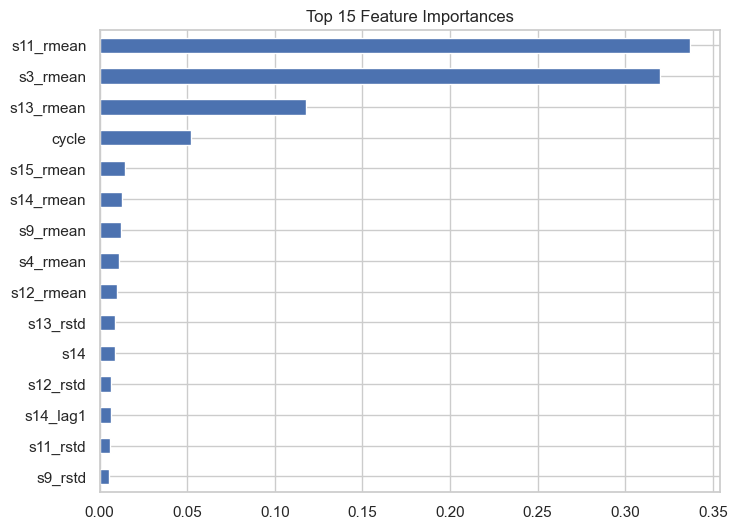

In [21]:
importances = pd.Series(
    final_model.feature_importances_,
    index=FEATURES
).sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances.head(15).plot(kind="barh")
plt.title("Top 15 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

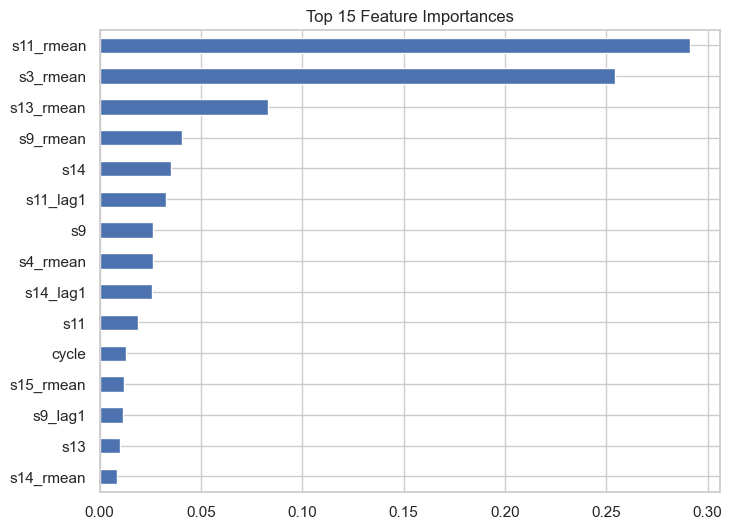

In [10]:
importances = pd.Series(
    final_model1.feature_importances_,
    index=FEATURES
).sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances.head(15).plot(kind="barh")
plt.title("Top 15 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [22]:

test_last_trial=test_df.groupby('unit').tail(1).reset_index(drop=True)
test_features_excluding_unit=test_last_trial[FEATURES].values

test_preds=final_model.predict(test_features_excluding_unit)

test_results=pd.DataFrame(
    {
        'unit':test_last_trial['unit'],
        'model_test_pred': test_preds
    }
)

test_results.shape

(248, 2)

In [ ]:

test_last_trial1=test_df.groupby('unit').tail(1).reset_index(drop=True)
test_features_excluding_unit1=test_last_trial1[FEATURES].values

test_preds1=final_model1.predict(test_features_excluding_unit1)

test_results1=pd.DataFrame(
    {
        'unit':test_last_trial1['unit'],
        'model_test_pred': test_preds1
    }
)

test_results1.shape

(248, 2)

In [13]:
dir_rul=Path("..")/"data/beforeProcessing"
test_RUL_org=pd.read_csv(dir_rul/"RUL_FD004.txt",sep=r"\s+",index_col=False,header=None)

test_RUL_org.tail()

,0
243,35
244,131
245,194
246,112
247,26


In [24]:
test_RUL_org=pd.read_csv(dir_rul/"RUL_FD004.txt",sep=r"\s+",index_col=False,header=None).iloc[:,0].values

rmse_test=np.sqrt(mean_squared_error(test_RUL_org,test_preds))
mae_test=mean_absolute_error(test_RUL_org,test_preds)

print(f"Test Set -> MAE= {mae_test:.2f} , RMSE= {rmse_test:.2f}")

Test Set -> MAE= 21.86 , RMSE= 29.50


In [26]:
test_RUL_org=pd.read_csv(dir_rul/"RUL_FD004.txt",sep=r"\s+",index_col=False,header=None).iloc[:,0].values

rmse_test=np.sqrt(mean_squared_error(test_RUL_org,test_preds1))
mae_test=mean_absolute_error(test_RUL_org,test_preds1)

print(f"Test Set -> MAE= {mae_test:.2f} , RMSE= {rmse_test:.2f}")

Test Set -> MAE= 21.70 , RMSE= 29.34


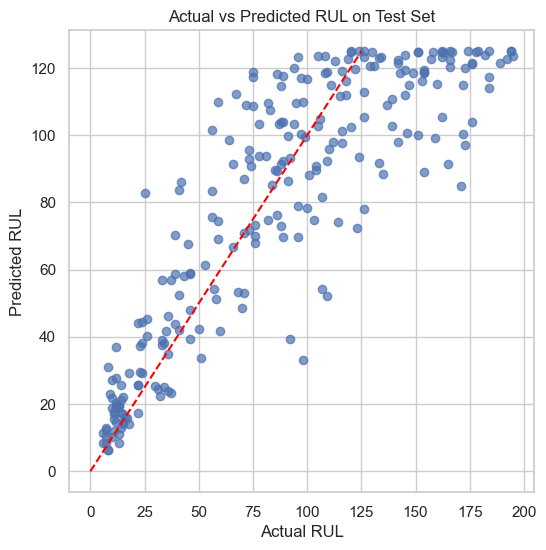

In [28]:
plt.figure(figsize=(6,6))
plt.scatter(test_RUL_org,test_preds,alpha=0.7)
plt.plot([0,125],[0,125],color='red',ls='--')
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Actual vs Predicted RUL on Test Set")
plt.show()

- The model predicts RUL accurately near end-of-life, which is the most critical operational  region. Prediction uncertainty increases for high RUL values due to limited sensor degradation signals and intentional RUL capping to focus learning on late-stage degradation.

- So, the model prediction of predictiing rul gets increased as the cycle increases for that engine by time.

Scenario:
- If an engine has 200 cycles left, nothing urgent is done
- If an engine has 10 cycles left, decisions are critical

there we want to know, how much would be the remaining rul, that the cycles can last upto.
It answers, Can the model warn when failure is near? Yes it can, bcoz the model was tested and documented as while approaching to higher cycles/low cycles left , it predicts well.


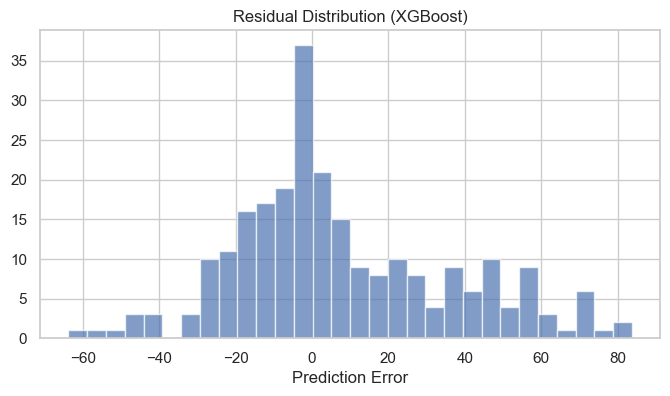

In [17]:
residuals=test_RUL_org-test_preds1

plt.figure(figsize=(8,4))
plt.hist(residuals, bins=30, alpha=0.7)
plt.title("Residual Distribution (XGBoost)")
plt.xlabel("Prediction Error")
plt.show()

In [18]:
results=pd.DataFrame({
    'unit':test_last_trial1['unit'],
    'test_RUL_org':test_RUL_org,
    'test_pred':test_preds1,
    'error':test_RUL_org - test_preds1
})

results.head()
results.to_csv(DATA_DIR/f"test_results_XGBoost_{FD}.csv",index=False)

### Modeling Summary — XGBoost (FD004)

- Model: XGBRegressor
- Target: RUL (capped at 125)
- Validation: GroupKFold by engine unit
- Features: Cluster-aware normalized temporal features
- CV RMSE: 16.53
- Test RMSE: 46.28

Observations:
- Strong accuracy near end-of-life (low RUL)
- Improved mid-life prediction compared to Random Forest
- Early-life uncertainty remains

Artifacts:
- best_xgb_fd004.pkl
- feature_list.pkl
- test prediction CSV
